In [1]:
import os
import pickle

import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import sklearn.utils

from model import FiringRateModel, PolynomialActivation
from train import train_model
from data import get_data, get_train_test_data
from evaluate import explained_variance_ratio
from utils import plot_predictions, plot_kernel
from config import config

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
    
print(device)

cpu


In [3]:
def train(Is, fs, g, cell_id, bin_size, ds=None, device=None):
    model = FiringRateModel(
        g.to(device), ds, bin_size=bin_size, device=device
    ).to(device)
    
    criterion = torch.nn.PoissonNLLLoss(log_input=False, reduction="none")
    optimizer = torch.optim.RMSprop(model.parameters(), lr=0.01, centered=True)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, gamma=0.85, step_size=5)

    # closed loop
    losses = train_model(
        model, 
        criterion, 
        optimizer,
        Is,
        fs,
        epochs = 10,
        print_every = 1,
        bin_size = bin_size,
        up_factor = 1,
        scheduler = scheduler
    )
    
    #with open(config["loss_save_path"] + f'{cell_id}.pickle', 'wb') as handle:
    #    pickle.dump(params, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    return model

In [4]:
cell_id, bin_size = 583836069, 20
ds = np.linspace(0.05, 1.0, 5)
data = get_data(cell_id, aligned=False)
Is_tr, fs_tr, Is_te, fs_te, stims = get_train_test_data(data, bin_size, device=device)
Is_tr, fs_tr, stims = sklearn.utils.shuffle(Is_tr, fs_tr, stims)

In [5]:
params = {}

actv = PolynomialActivation()
actv.init_from_file(f"model/activation/poisson/bin_size_{bin_size}/{cell_id}_0.pickle")
model = train(Is_tr, fs_tr, actv, cell_id, bin_size, ds=ds, device=device)
#params[cell_id] = model.get_params()

#with open('model/params.pickle', 'wb') as handle:
#    pickle.dump(params, handle, protocol=pickle.HIGHEST_PROTOCOL)

Train model:  10%|███                            | 1/10 [00:00<00:04,  2.10it/s]

Epoch 1 / Loss: 7871.789284706116 / lr: [0.01]


Train model:  20%|██████▏                        | 2/10 [00:00<00:03,  2.01it/s]

Epoch 2 / Loss: 7141.444336891174 / lr: [0.01]


Train model:  30%|█████████▎                     | 3/10 [00:01<00:03,  2.07it/s]

Epoch 3 / Loss: 6469.610085487366 / lr: [0.01]


Train model:  40%|████████████▍                  | 4/10 [00:01<00:02,  2.10it/s]

Epoch 4 / Loss: 5802.204400062561 / lr: [0.01]


Train model:  50%|███████████████▌               | 5/10 [00:02<00:02,  2.10it/s]

Epoch 5 / Loss: 5147.163926124573 / lr: [0.0085]


Train model:  60%|██████████████████▌            | 6/10 [00:02<00:01,  2.06it/s]

Epoch 6 / Loss: 4306.5522718429565 / lr: [0.0085]


Train model:  70%|█████████████████████▋         | 7/10 [00:03<00:01,  2.07it/s]

Epoch 7 / Loss: 3320.6966733932495 / lr: [0.0085]


Train model:  80%|████████████████████████▊      | 8/10 [00:03<00:00,  2.09it/s]

Epoch 8 / Loss: 2177.19504070282 / lr: [0.0085]


Train model:  90%|███████████████████████████▉   | 9/10 [00:04<00:00,  2.06it/s]

Epoch 9 / Loss: 1245.8630380630493 / lr: [0.0085]


Train model: 100%|██████████████████████████████| 10/10 [00:04<00:00,  2.08it/s]

Epoch 10 / Loss: 558.3485422134399 / lr: [0.0072250000000000005]


/Users/calvin.yeung/Documents/GitHub/GRNN/utils.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(3)


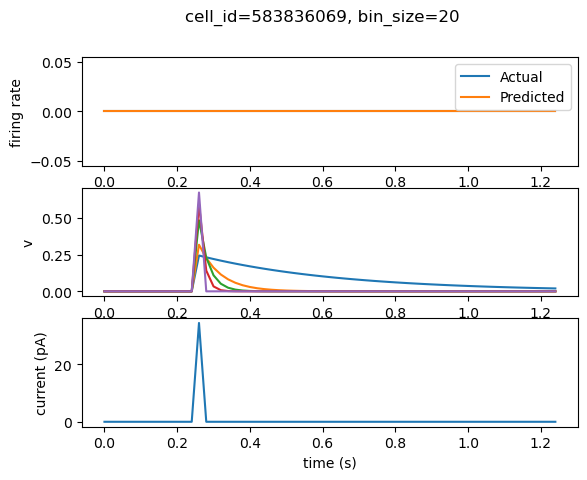

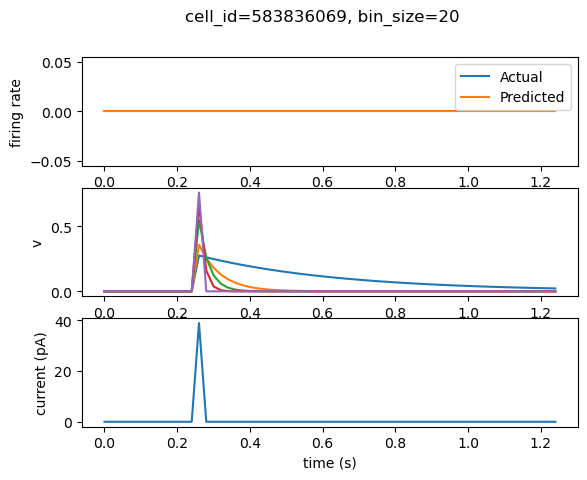

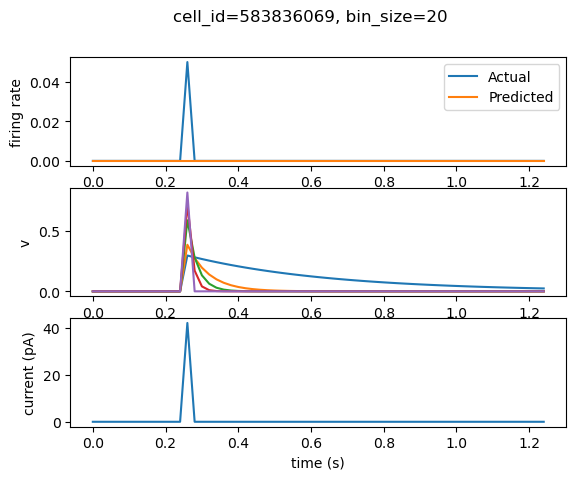

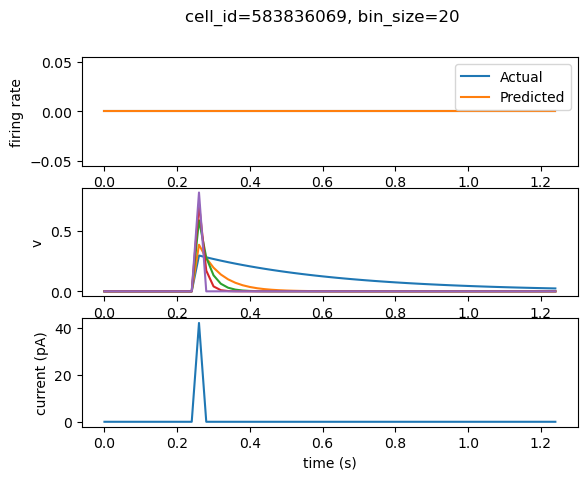

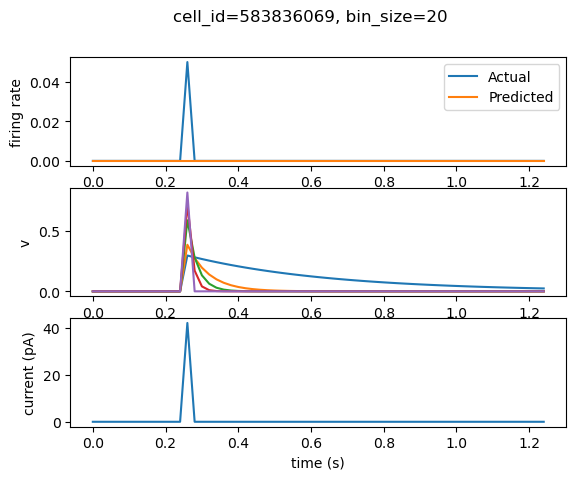

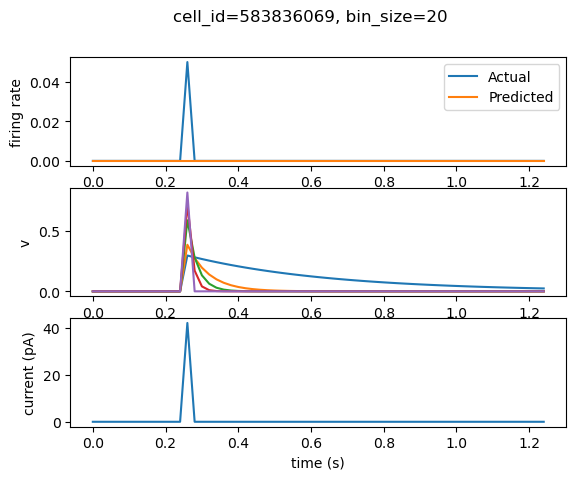

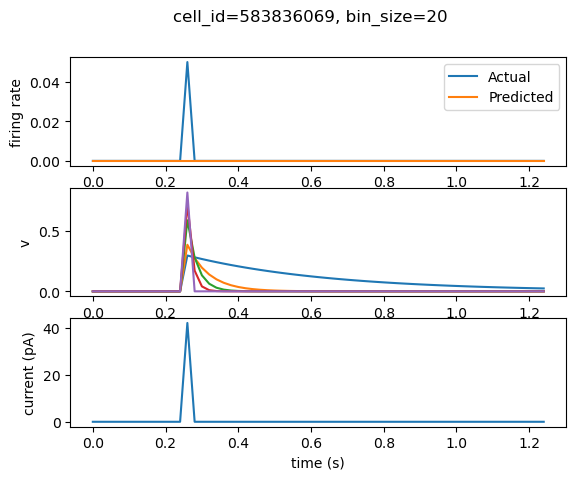

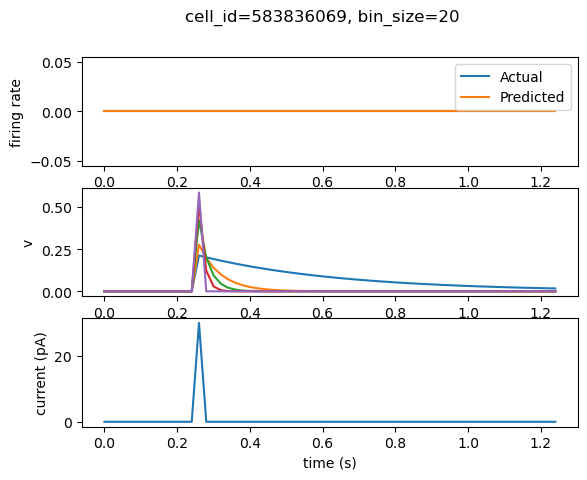

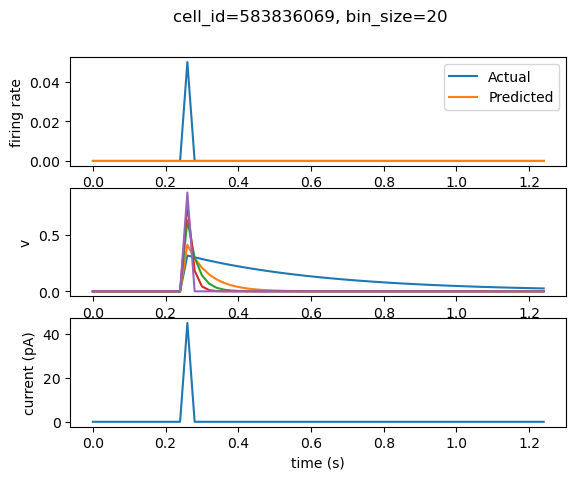

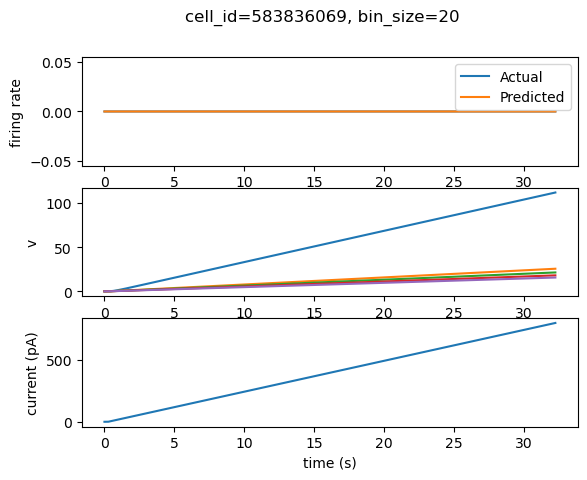

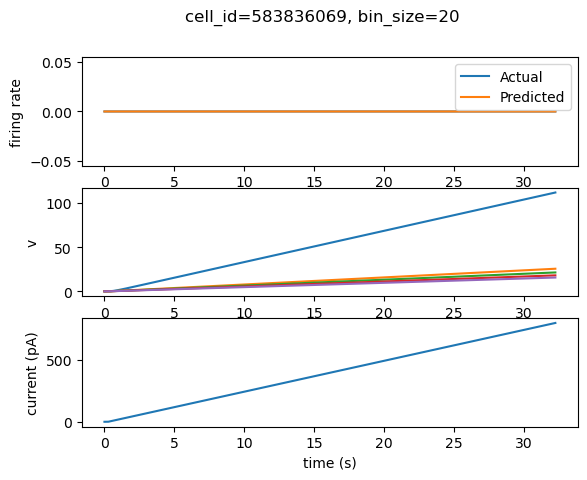

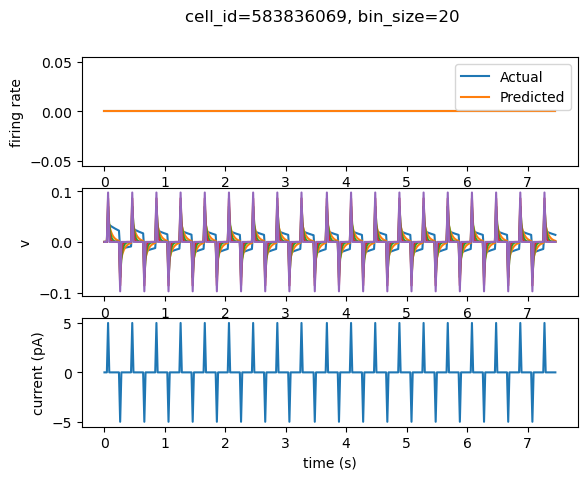

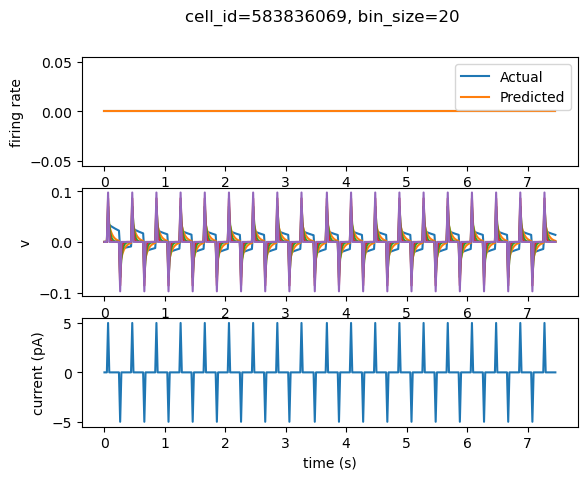

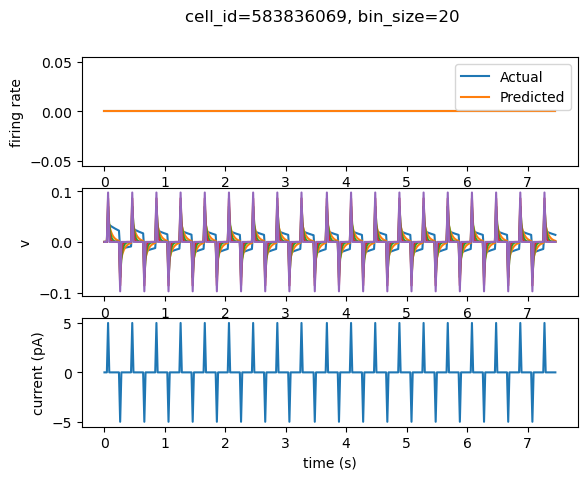

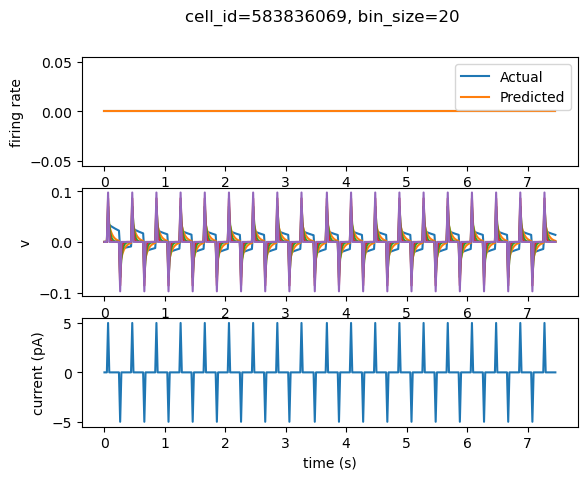

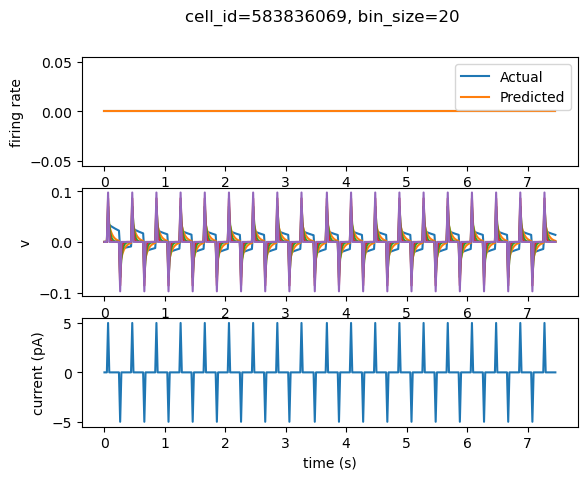

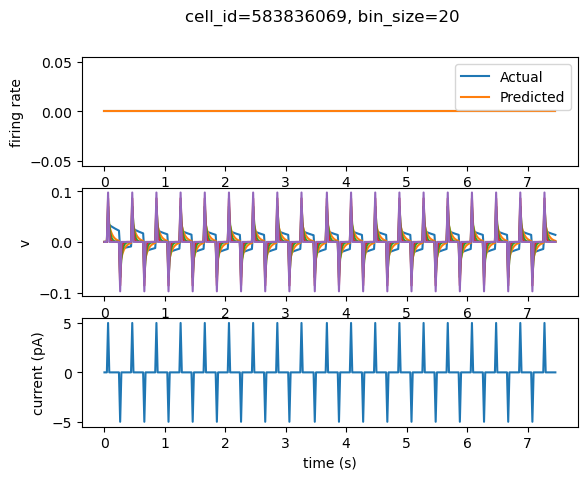

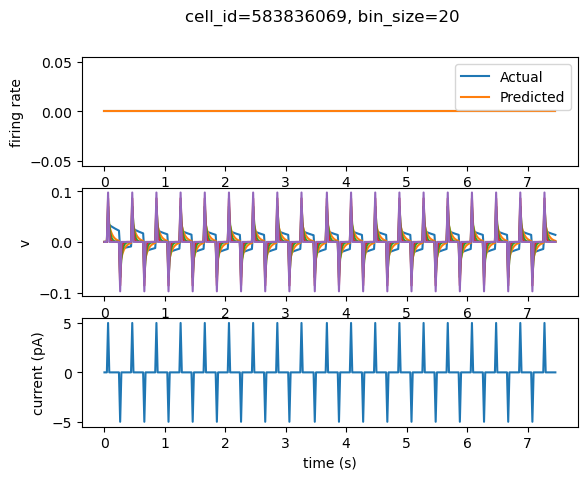

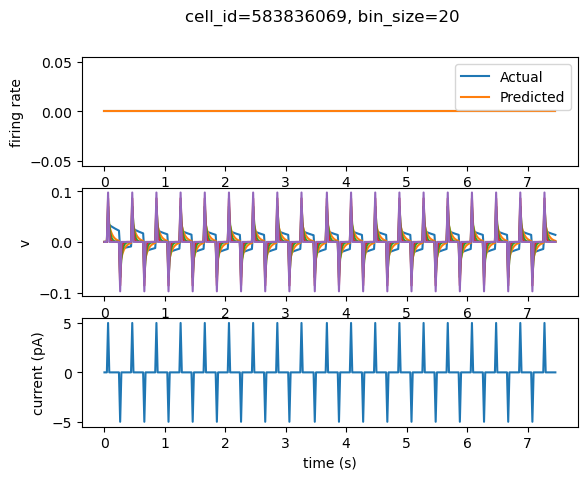

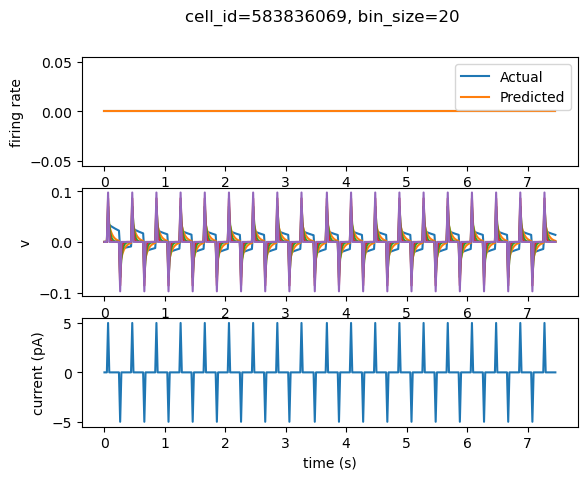

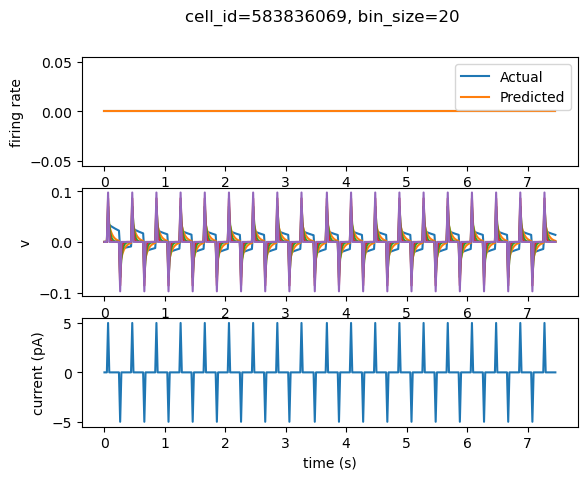

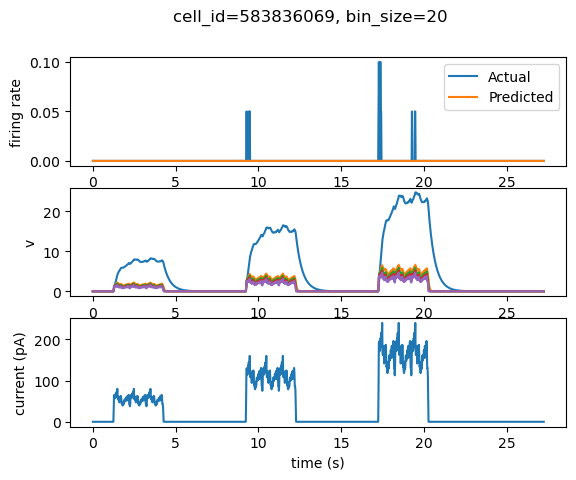

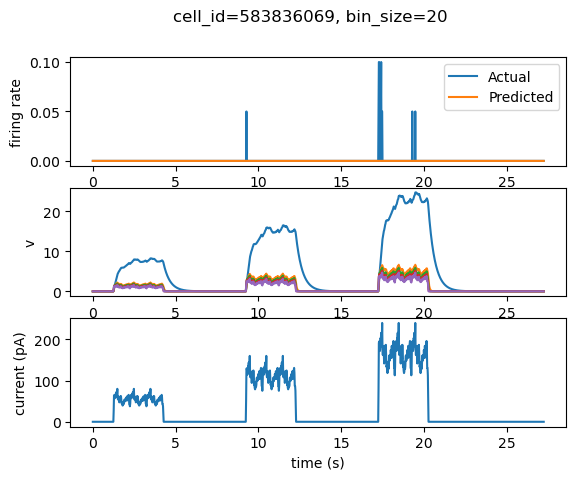

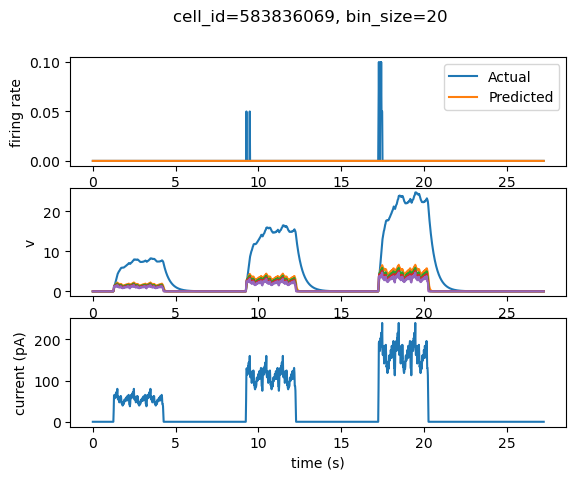

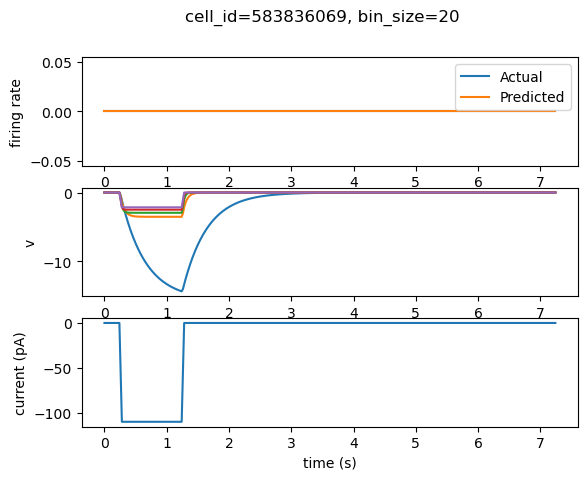

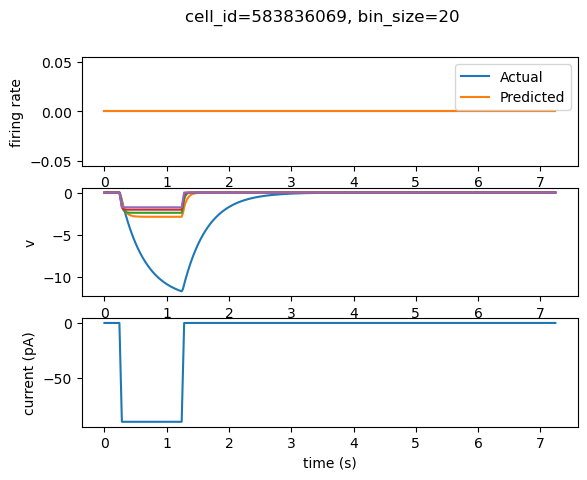

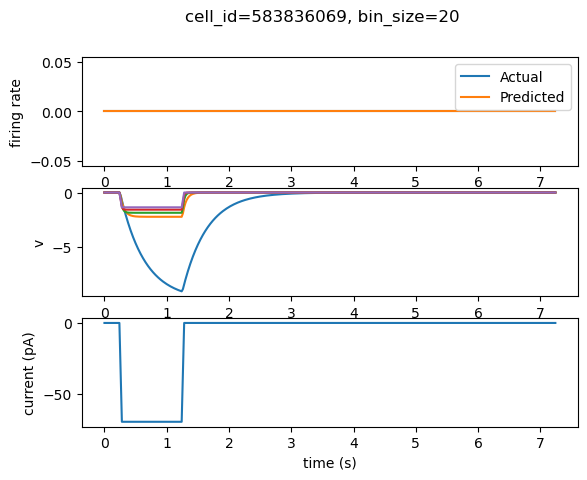

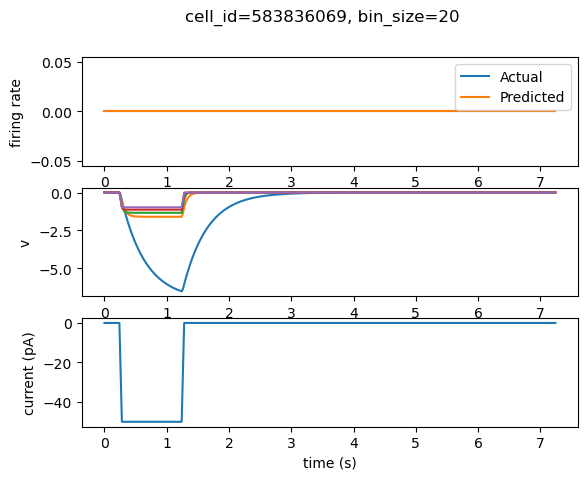

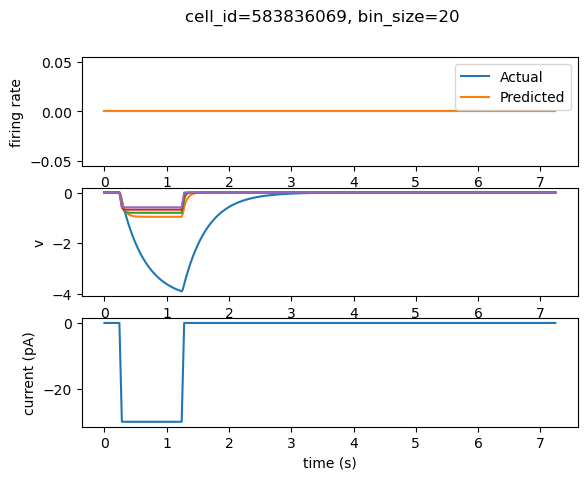

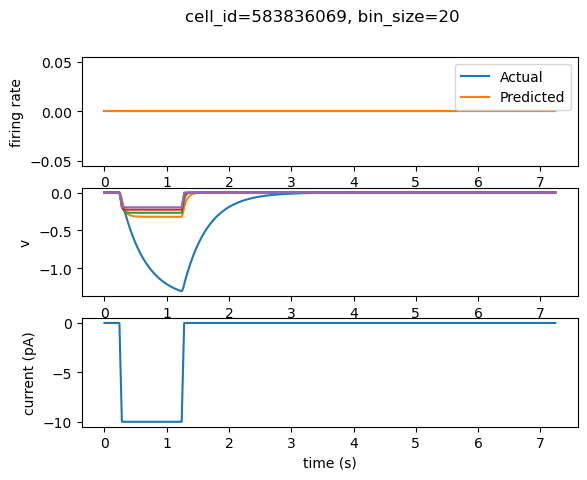

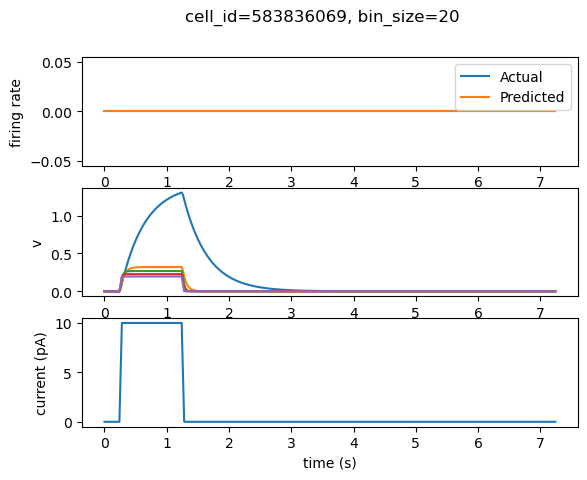

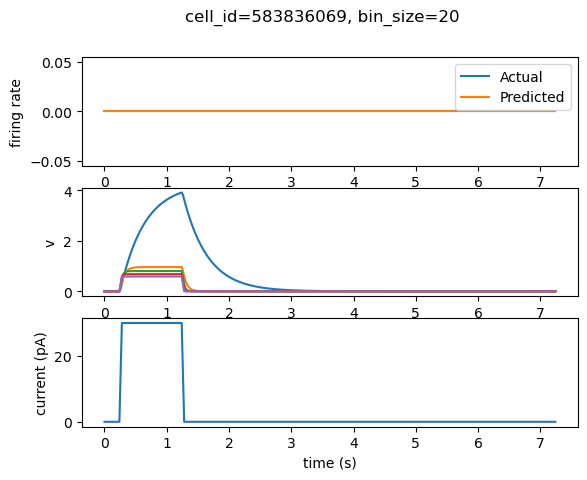

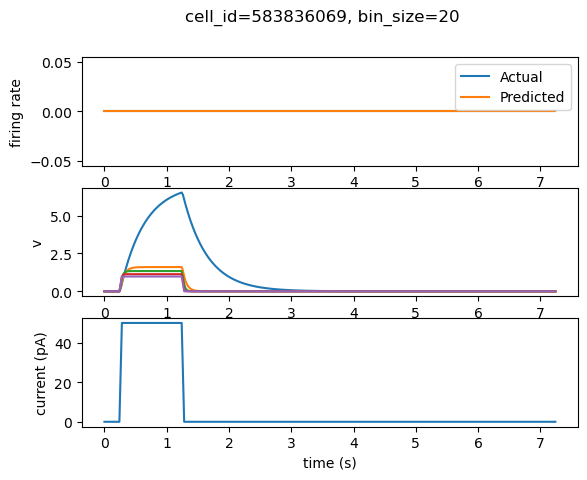

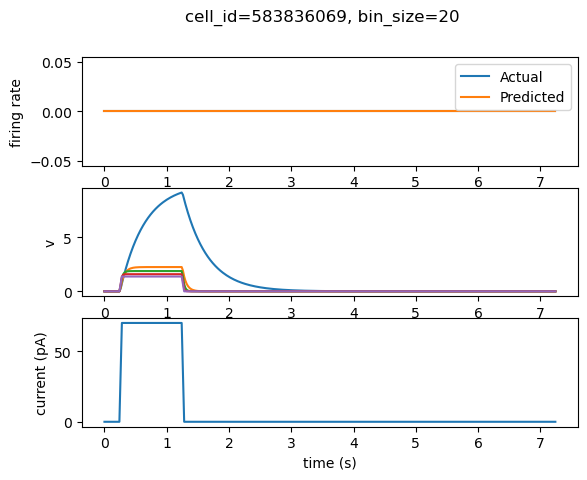

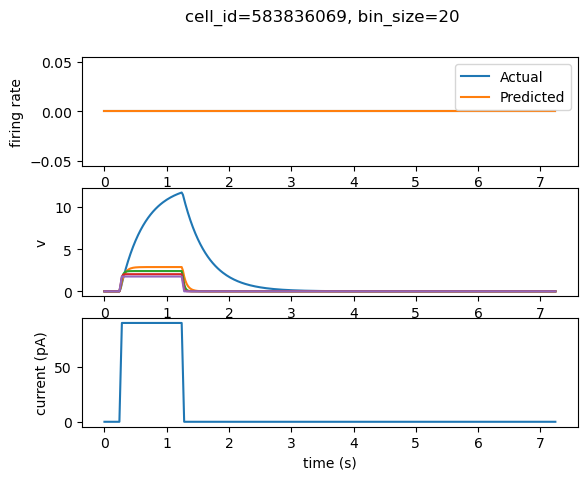

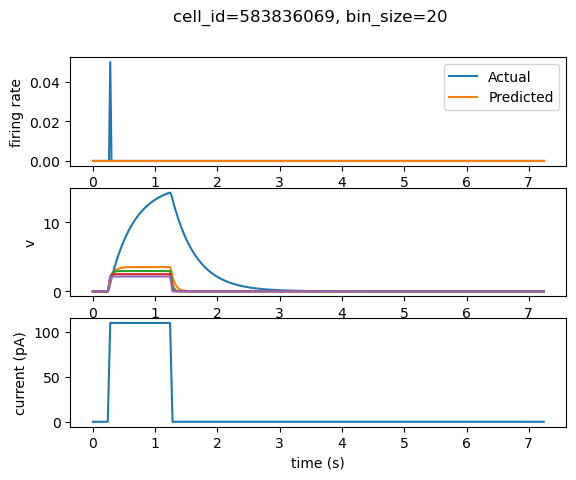

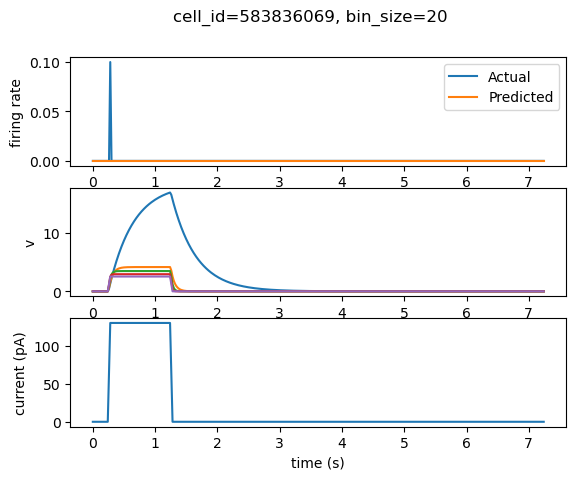

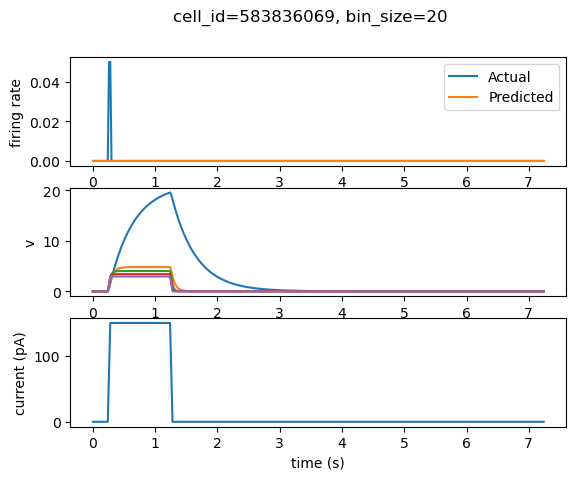

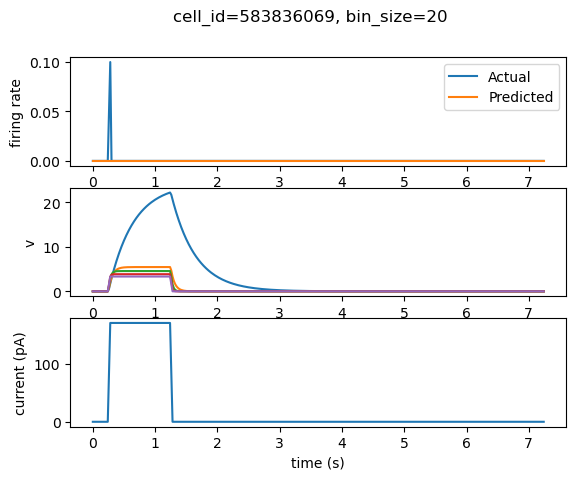

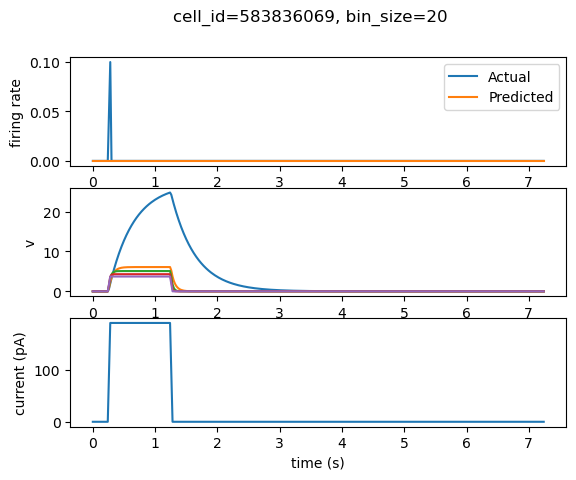

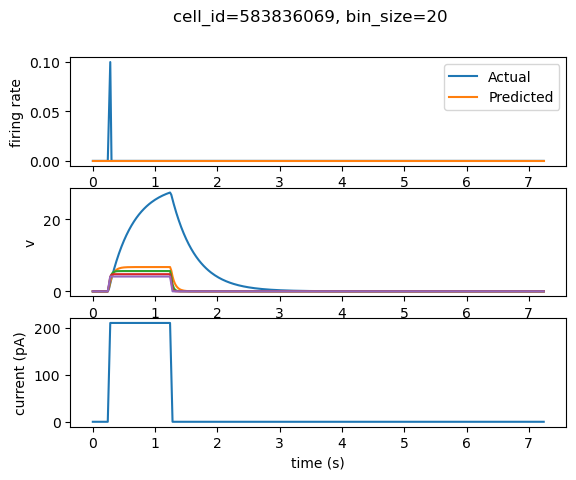

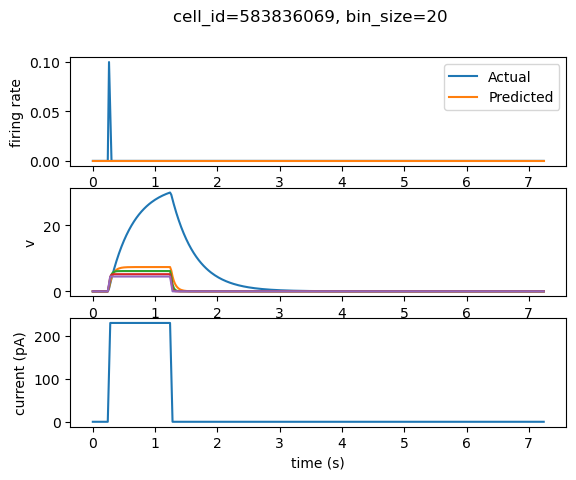

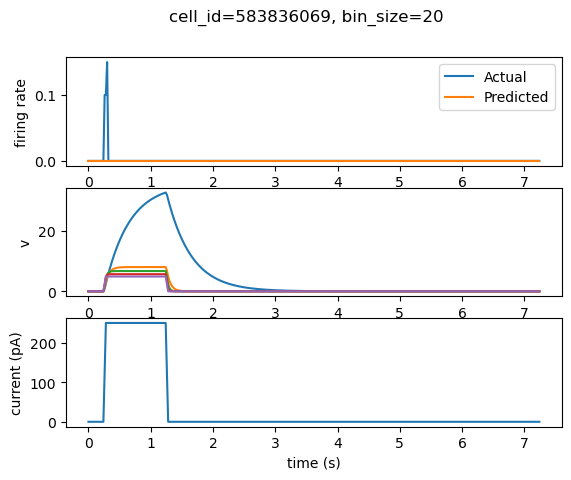

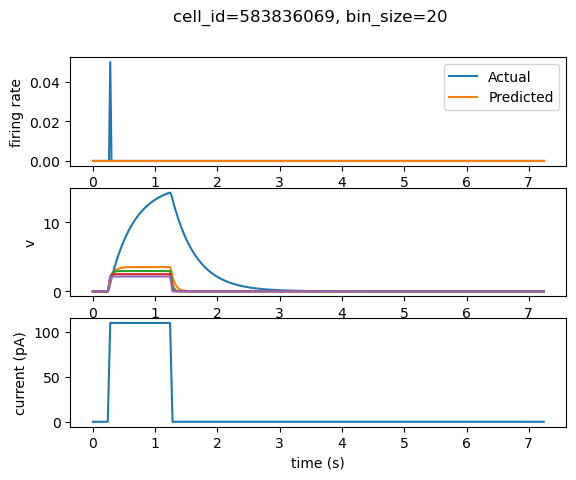

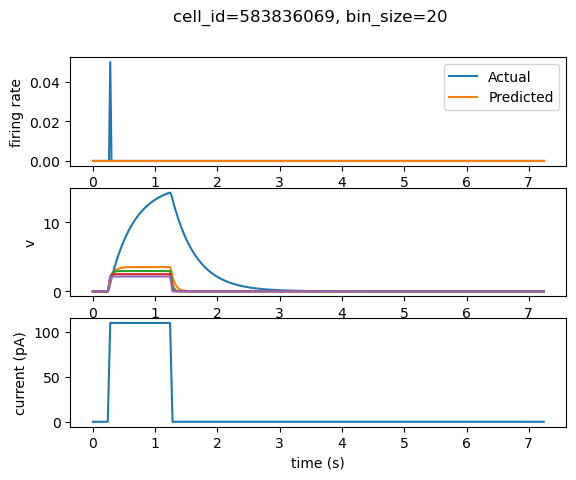

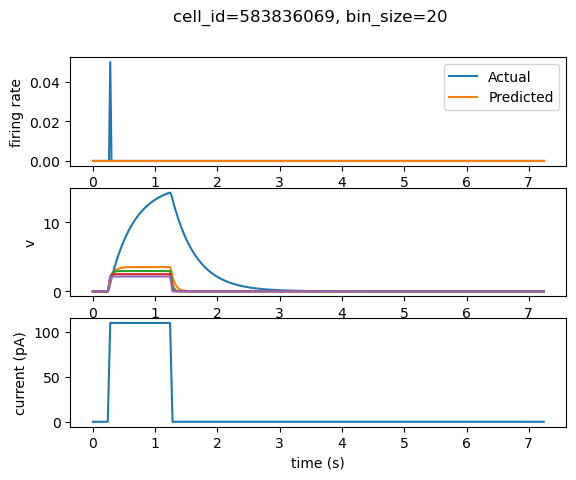

In [6]:
save = False

for Is, fs, s in zip(Is_tr, fs_tr, stims):
    for i in range(Is.shape[0]):
        plot_predictions(
            model, 
            Is[i, :], 
            fs[i, :], 
            cell_id, 
            bin_size, 
            evr = None,
            save = save,
            fname = f"{s} {i}"
        )

/Users/calvin.yeung/Documents/GitHub/GRNN/evaluate.py:10: RuntimeWarning: invalid value encountered in scalar divide
  return (v1 + v2 - v3) / (v1 + v2)
/Users/calvin.yeung/Documents/GitHub/GRNN/evaluate.py:10: RuntimeWarning: divide by zero encountered in scalar divide
  return (v1 + v2 - v3) / (v1 + v2)


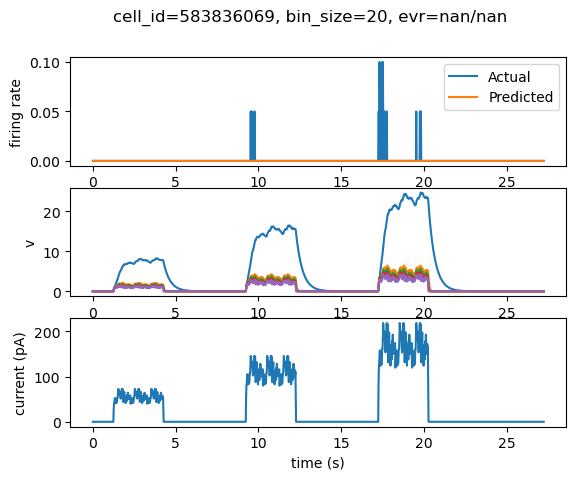

In [7]:
r = explained_variance_ratio(model, Is_te[0][0, :], fs_te[0][0, :], bin_size)
rq = explained_variance_ratio(model, Is_te[0][0, :], fs_te[0][0, :], bin_size, quantize=True)
plot_predictions(
    model, 
    Is_te[0][0, :], 
    fs_te[0][0, :], 
    cell_id, 
    bin_size, 
    evr = (r, rq),
    save = save,
    fname = f"Noise 2"
)

AttributeError: 'list' object has no attribute 'reshape'

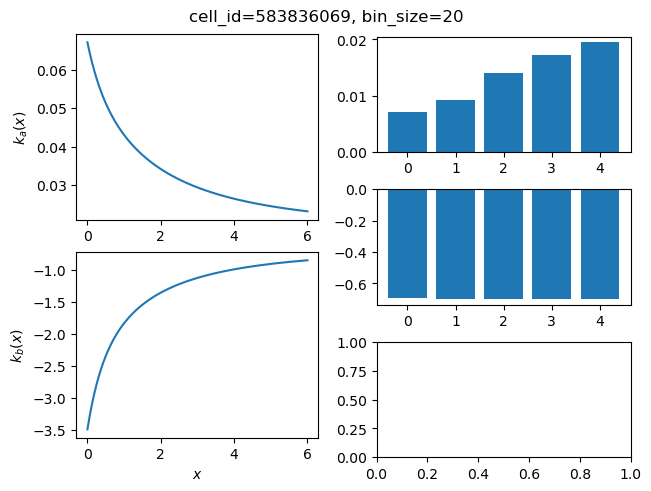

In [8]:
plot_kernel(
    model,
    cell_id,
    bin_size,
    save = save,
    fname = "Kernel"
)